# **Developing a CNN to Classify Augmented CMB Maps with Different String Tensions**

This notebook is divided into three sections:


1.   Importing, formatting and creating the data
2.   Building a pipeline and creating a CNN model
3.   Analysing the results



In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import os

from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, \
Dropout, AveragePooling2D, BatchNormalization
from tensorflow.keras.models import Sequential
from matplotlib.colors import ListedColormap

In [2]:
# Mount google drive folder with .fits maps
from google.colab import drive
drive.mount('/content/drive')

# Change directory
os.chdir('drive/MyDrive/Project')

Mounted at /content/drive


In [4]:
# Colour map
cmap = ListedColormap(np.loadtxt('planck_map.txt')/255.)

# **Handling the data**

Below, we import our 5000 CMB and 2700 string cutouts. The CMB cutouts were generated by extracting 20 cutouts from each of 250 full-sky maps, whereas the 2700 string cutouts were generated from 3 full-sky maps.

These images have a resolution of 1.5 arcmin.

In [5]:
# Import cmb and string maps
cmb = np.load('cmb_5000_extracts_highres.npy')

string = np.concatenate([np.load('string_map_extracts_1_res_1_5.npy'),
                         np.load('string_map_extracts_2_res_1_5.npy'),
                         np.load('string_map_extracts_3_res_1_5.npy')])

# Add channel dimension
cmb = cmb[..., np.newaxis]
string = string[..., np.newaxis]

print(cmb.shape)
print(string.shape)

(5000, 200, 200, 1)
(2700, 200, 200, 1)


We will split the data into two different groups:



1.   Training set - this will be used to train our model. This will use 2212 base CMB cutouts and 1896 string cutouts, so that each of the classes contains 316 samples.
2.   Validation set - this will be used during training to check performance on unseen maps. This will use 469 base CMB cutouts and 402 string cutouts, so each class will contain 67 samples.
3.   Test set - this will be used as a final evaluation of our model's performance. This will use 469 base CMB cutouts and 402 string cutouts, so each class will contain 67 samples.

Note that this leaves 1850 samples from our original CMB dataset unused.

We will use the following labelling convention:

First, we will shuffle our arrays.



In [6]:
# Shuffle cmb and string maps using different seeds.
np.random.shuffle(cmb)
np.random.shuffle(string)

Here, we create the training set by taking the first 1896 and 2212 images from the (now shuffled) string and cmb map arrays, respectively.

For this version, we are going to try including different values of alpha based on the results from previous trials

In [20]:
# Slice cmb array
X_train_cmb = cmb[:2212]

# Slice string array and also add placeholder string arrays for the cmb maps
# that we won't augment
nan_string = np.empty(shape=(316, 200, 200, 1))
nan_string[:] = np.NaN
X_train_string = np.concatenate([nan_string, string[:1896]])

# Label data
y_train = np.concatenate([[0]*316, [2]*316, [4]*316, [6]*316,
                             [8]*316, [10]*316, [12]*316])

# Alpha vlaues
alpha_train = np.concatenate([[0]*316, [2e-6]*316, [4e-6]*316, [6e-6]*316,
                             [8e-6]*316, [10e-6]*316, [12e-6]*316])

# Shuffle all arrays with same seed
np.random.RandomState(7).shuffle(X_train_cmb)
np.random.RandomState(7).shuffle(X_train_string)
np.random.RandomState(7).shuffle(y_train)
np.random.RandomState(7).shuffle(alpha_train)

print(X_train_cmb.shape)
print(X_train_string.shape)
print(y_train.shape)
print(alpha_train.shape)

print(y_train[:20])
print(alpha_train[:20])

(2212, 200, 200, 1)
(2212, 200, 200, 1)
(2212,)
(2212,)
[12  8  2  4  4  8  0  6 12 12  4  6  0 12  2  2  6  8  6 10]
[1.2e-05 8.0e-06 2.0e-06 4.0e-06 4.0e-06 8.0e-06 0.0e+00 6.0e-06 1.2e-05
 1.2e-05 4.0e-06 6.0e-06 0.0e+00 1.2e-05 2.0e-06 2.0e-06 6.0e-06 8.0e-06
 6.0e-06 1.0e-05]


12


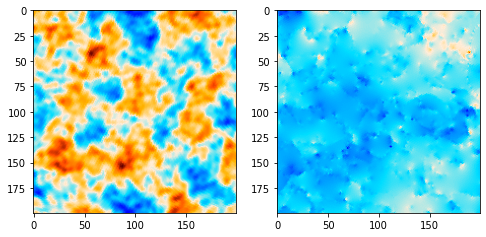

In [21]:
fig, ax = plt.subplots(1, 2, figsize=(8, 4))
ax[0].imshow(X_train_cmb[0].reshape(200, 200), cmap=cmap)
ax[1].imshow(X_train_string[0].reshape(200, 200), cmap=cmap)
print(y_train[0])

Then, we create the validation set. These arrays will not undergo augmentations on the fly, so we will create the augmented CMB maps through a straight addition with the by a multiplicative constant, $\alpha$.

Our string maps' colour scale gives a measure of $\frac{\Theta}{GU}$. The multiplicative constant we use will give an indication of the string tension.

In [22]:
# Set up images for different classes
X_val = np.concatenate((cmb[2212:2279],
                        cmb[2279:2346] + 2e-6*string[1896:1963],
                        cmb[2346:2413] + 4e-6*string[1963:2030],
                        cmb[2413:2480] + 6.5e-6*string[2030:2097],
                        cmb[2480:2547] + 8e-6*string[2097:2164],
                        cmb[2547:2614] + 10e-6*string[2164:2231],
                        cmb[2614:2681] + 12e-6*string[2231:2298]))

# Label data
y_val = np.concatenate([[0]*67, [2]*67, [4]*67, [6]*67,
                             [8]*67, [10]*67, [12]*67])

# Shuffle X_val, y_val with same seed
np.random.RandomState(14).shuffle(X_val)
np.random.RandomState(14).shuffle(y_val)

print(X_val.shape)
print(y_val.shape)

(469, 200, 200, 1)
(469,)



We do the same and generate our test set.

In [23]:
# Set up images for different classes
X_test = np.concatenate((cmb[2681:2748],
                        cmb[2748:2815] + 3e-6*string[2298:2365],
                        cmb[2815:2882] + 4e-6*string[2365:2432],
                        cmb[2882:2949] + 6e-6*string[2432:2499],
                        cmb[2949:3016] + 8e-6*string[2499:2566],
                        cmb[3016:3083] + 10e-6*string[2566:2633],
                        cmb[3083:3150] + 12e-6*string[2633:]))

# Label data
y_test = np.concatenate([[0]*67, [2]*67, [4]*67, [6]*67,
                             [8]*67, [10]*67, [12]*67])

# Shuffle X_val, y_val with same seed
np.random.RandomState(28).shuffle(X_test)
np.random.RandomState(28).shuffle(y_test)

print(X_test.shape)
print(y_test.shape)

(469, 200, 200, 1)
(469,)


We can alternatively generate a test set with an equal spacing of alpha values. (Note that this reduces the size of the data set as we don't have enough string maps without all the maps with none applied)

In [24]:
# Equally spaced values of alpha used
alpha_test = np.linspace(0, 12e-6, num=402)
num_test = 402

# Loop used to generate each test image
X_test = [None]*num_test
for n in range(num_test):
  X_test[n] = cmb[2681+n] + alpha_test[n]*string[2298+n]
X_test = np.array(X_test)

# Label data
y_test = alpha_test*1e6

# Shuffle X_val, y_val with same seed
np.random.RandomState(28).shuffle(X_test)
np.random.RandomState(28).shuffle(y_test)

print(X_test.shape)
print(y_test.shape)

(402, 200, 200, 1)
(402,)


We also need to load up and shuffle our data set from the real CMB map

In [12]:
# Import and add channel axis
cmb_cutouts = np.load('Real_CMB_extracts.npy')[..., np.newaxis]
# Shuffle images
np.random.RandomState(7).shuffle(cmb_cutouts)


Below, we plot some images from our validation and test sets.

9.0
1.5
5.049875311720698
6.957605985037406


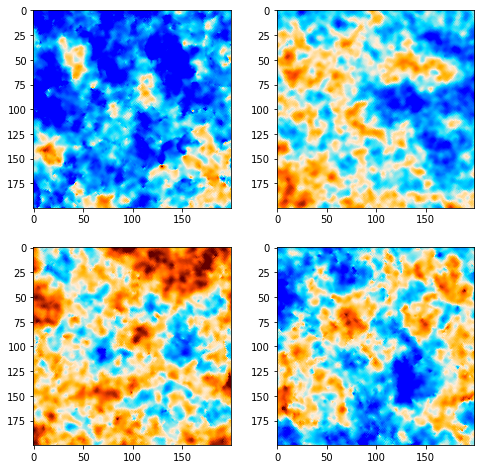

In [13]:
print(y_val[0])
print(y_val[47])

print(y_test[4])
print(y_test[1])

fig, axes = plt.subplots(2, 2, figsize=(8, 8))
axes[0, 0].imshow(X_val[0].reshape(200, 200), cmap=cmap,
                  vmin=-300e-6, vmax=300e-6)
axes[0, 1].imshow(X_val[47].reshape(200, 200), cmap=cmap,
                  vmin=-300e-6, vmax=300e-6)
axes[1, 0].imshow(X_test[4].reshape(200, 200), cmap=cmap,
                  vmin=-300e-6, vmax=300e-6)
axes[1, 1].imshow(X_test[1].reshape(200, 200), cmap=cmap,
                  vmin=-300e-6, vmax=300e-6)

# **Building the pipeline and CNN model**

In this section we will build the pipeline and CNN. First we introduce three functions: two types of batch normalisation functions and another function that will perform random string augmentations on the fly on our training set.

In [14]:
def batch_standardisation(maps, labels):
  epsilon = 1e-10
  mean, variance = tf.nn.moments(maps, axes=[0, 1, 2])
  denom = tf.math.sqrt(variance + epsilon)
  maps_standardised = (maps - mean)/denom
  return maps_standardised, labels

In [15]:
def batch_normalisation(maps, labels):
  min_val = tf.math.reduce_min(maps, axis=[0, 1, 2])
  max_val = tf.math.reduce_max(maps, axis=[0, 1, 2])
  denom = max_val - min_val
  maps_normalised = (maps - min_val)/denom
  return maps_normalised, labels

In [16]:
def selective_string_maps(string_map, cmb_map, label, alpha):
  # label value
  N = np.int(label)

  # Transformation: rotate CMB map
  # Output: rotated CMB map and original label
  def rotation():
    cmb_rot = tf.image.rot90(cmb_map, tf.random.uniform(shape=[], minval=0,
                                          maxval=4, dtype=tf.int32))
    
    return cmb_rot, label

  # Transformation: introduce discontinuities to CMB map
  # Output: discontinuity map and original label
  def add_string():
    string_rot = tf.image.rot90(string_map, tf.random.uniform(shape=[], minval=0,
                                maxval=4, dtype=tf.int32))
    string_scaled = tf.multiply(string_rot, alpha)
    cmb_rot = tf.image.rot90(cmb_map, tf.random.uniform(shape=[], minval=0,
                            maxval=4, dtype=tf.int32))
    aug_cmb = tf.add(cmb_rot, string_scaled)
    return aug_cmb, label

  return tf.cond(N == 0, true_fn=rotation, false_fn=add_string)

We may now define our CNN model.

In [17]:
# Build model
def build_model():
  model = Sequential([Conv2D(32, (3, 3), padding='same', activation='relu'),
                      Conv2D(32, (3, 3), padding='same', activation='relu'),
                      Conv2D(32, (3, 3), padding='same', activation='relu'),
                      Conv2D(32, (3, 3), padding='same', activation='relu'),
                      MaxPooling2D(2),
                      Flatten(),
                      Dense(128, activation='relu'),
                      Dense(1)
                      ])
  optimizer = tf.keras.optimizers.Adam(0.001)
  model.compile(optimizer=optimizer,
              loss=tf.keras.losses.MeanSquaredError(),
              metrics=tf.keras.metrics.MeanAbsoluteError())
  return model

And finally we build our pipelines and test our CNN model. We can use either one of the batch functions.

In [26]:
# Create datasets
train_ds = tf.data.Dataset.from_tensor_slices((X_train_string, X_train_cmb,
                                               y_train, alpha_train))
val_ds = tf.data.Dataset.from_tensor_slices((X_val, y_val))
test_ds = tf.data.Dataset.from_tensor_slices((X_test, y_test))

# Train dataset pipeline
train_ds = train_ds.map(selective_string_maps)
train_ds = train_ds.shuffle(100)
train_ds = train_ds.batch(64)
train_ds = train_ds.map(batch_standardisation)
train_ds = train_ds.prefetch(1)

# Validation dataset pipeline
val_ds = val_ds.batch(64)
val_ds = val_ds.map(batch_standardisation)
val_ds = val_ds.prefetch(1)

# Test dataset pipeline
test_ds = test_ds.batch(64)
test_ds = test_ds.map(batch_standardisation)
test_ds = test_ds.prefetch(1)

model = build_model()

callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=20,
                                            restore_best_weights=True)

history = model.fit(train_ds, epochs=100, verbose=1, validation_data=val_ds,
                    callbacks=[callback])
print(model.summary())

Epoch 1/100
35/35 [==============================] - 5s 122ms/step - loss: 263.5025 - mean_absolute_error: 9.0374 - val_loss: 12.0201 - val_mean_absolute_error: 2.8676
Epoch 2/100
35/35 [==============================] - 4s 118ms/step - loss: 9.4960 - mean_absolute_error: 2.5743 - val_loss: 9.2619 - val_mean_absolute_error: 2.5442
Epoch 3/100
35/35 [==============================] - 4s 119ms/step - loss: 8.4634 - mean_absolute_error: 2.4286 - val_loss: 8.5507 - val_mean_absolute_error: 2.4059
Epoch 4/100
35/35 [==============================] - 4s 119ms/step - loss: 7.3618 - mean_absolute_error: 2.2533 - val_loss: 9.7382 - val_mean_absolute_error: 2.4385
Epoch 5/100
35/35 [==============================] - 4s 119ms/step - loss: 6.7375 - mean_absolute_error: 2.1002 - val_loss: 5.7994 - val_mean_absolute_error: 1.8573
Epoch 6/100
35/35 [==============================] - 4s 119ms/step - loss: 4.2949 - mean_absolute_error: 1.6562 - val_loss: 2.2360 - val_mean_absolute_error: 1.1510
Epoch 7

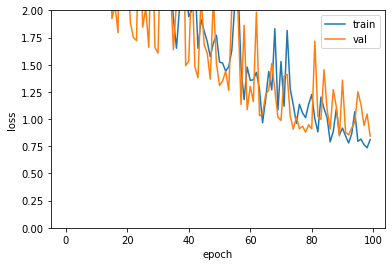

In [27]:
fig, ax = plt.subplots()
ax.plot(history.history['loss'], label='train')
ax.plot(history.history['val_loss'], label='val')
ax.set_xlabel('epoch')
ax.set_ylabel('loss')
plt.ylim(0,2)
plt.legend()

plt.savefig('loss_regression.png', dpi=300, bbox_inches='tight')

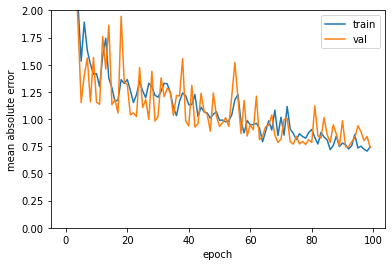

In [28]:
fig, ax = plt.subplots()
ax.plot(history.history['mean_absolute_error'], label='train')
ax.plot(history.history['val_mean_absolute_error'], label='val')
ax.set_xlabel('epoch')
ax.set_ylabel('mean absolute error')
plt.ylim(0,2)
plt.legend()

plt.savefig('mean_absolute_error.png', dpi=300, bbox_inches='tight')

In [20]:
epsilon = 1e-10
mean = np.mean(X_val, axis=(0, 1, 2))
variance = np.var(X_val, axis=(0, 1, 2))

X_test_norm = (X_test - mean)/np.sqrt((variance + epsilon))

Not done this properly for now, but I've just been trying to see what it's predicting for the different values and I think they look kind of close? (ish)

In [21]:

print(y_test[:50])

[0.7605985  3.86533666 3.11720698 2.53117207 2.80548628 3.57855362
 3.96508728 2.46882793 4.63840399 1.75810474 2.90523691 0.58603491
 4.06483791 3.89027431 2.05735661 4.3765586  0.77306733 4.01496259
 3.32917706 2.24438903 3.09226933 4.83790524 1.9201995  1.63341646
 4.40149626 1.72069825 1.70822943 4.70074813 0.24937656 1.97007481
 3.50374065 0.07481297 3.60349127 3.65336658 3.59102244 4.27680798
 2.96758105 2.34413965 1.00997506 3.840399   0.57356608 0.89775561
 3.66583541 0.12468828 3.17955112 0.66084788 4.11471322 3.82793017
 3.02992519 4.05236908]


In [29]:
predictions = model.predict(test_ds)

In [30]:
score = predictions.flatten()[13]    
print(score)

10.539167


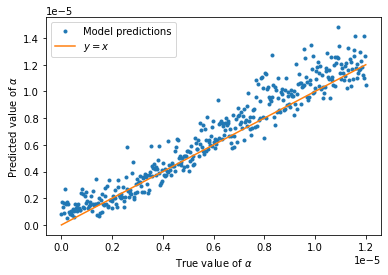

In [33]:
fig, ax = plt.subplots()
ax.plot(y_test*1e-6, predictions.flatten()*1e-6,'.', label='Model predictions')
x_line = [0,12e-6]
y_line = [0,12e-6]
ax.plot(x_line, y_line, label='$y=x$')

ax.set_xlabel(r'True value of $\alpha$')
ax.set_ylabel(r'Predicted value of $\alpha$')
plt.legend()

# plt.savefig('alpha_comparison.png', dpi=300, bbox_inches='tight')

Now, running predictions on the real CMB dataset

In [34]:
def batch_standardisation_no_labels(maps):
  epsilon = 1e-10
  mean, variance = tf.nn.moments(maps, axes=[0, 1, 2])
  denom = tf.math.sqrt(variance + epsilon)
  maps_standardised = (maps - mean)/denom
  return maps_standardised

In [35]:
# Real CMB dataset pipeline
cmb_ds = tf.data.Dataset.from_tensor_slices((cmb_cutouts))
cmb_ds = cmb_ds.batch(16)
cmb_ds = cmb_ds.map(batch_standardisation_no_labels)

In [36]:
predictions_CMB = model.predict(cmb_ds)

In [37]:
predictions_CMB.shape

(792, 1)

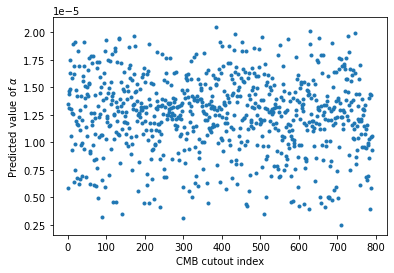

In [38]:
fig, ax = plt.subplots()
indices = np.arange(0,792)
ax.plot(indices, predictions_CMB.flatten()*1e-6,'.', label='Model predictions')

ax.set_xlabel(r'CMB cutout index')
ax.set_ylabel(r'Predicted value of $\alpha$')

plt.savefig('cmb_prediction.png', dpi=300, bbox_inches='tight')

We want to look at which maps are giving the highest and lowest $\alpha$ values.

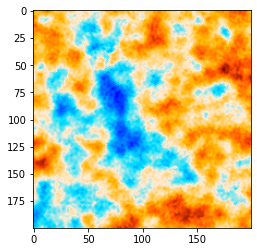

In [89]:
sorted_indices = np.argsort(predictions_CMB.flatten())

# Visualising the maps
fig, ax = plt.subplots()
ax.imshow(cmb_cutouts[sorted_indices[400]].reshape(200, 200), cmap=cmap)

In [70]:
# np.save('Regression_model_real_cmb_results.npy', predictions_CMB)

We can save this model to reliably access the trained model which achieved this level of validation loss at a future data

In [37]:
# model.save('regression_model_val_loss_0_2314')

INFO:tensorflow:Assets written to: regression_model_val_loss_0_2314/assets
